In [1]:
import shutil

shutil.unpack_archive('/kaggle/input/fpus23-background-class-generation/Side_data.zip', './', 'zip')

In [2]:
import torch, torchvision, time, os, copy, random, imageio, os, shutil,timm
import torch.nn as nn, matplotlib.pyplot as plt, seaborn as sn, pandas as pd
import torch.optim as optim, numpy as np
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix

In [3]:
Num_class = 2

model_ft = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=Num_class)
num_ftrs = model_ft.head.in_features


#model_ft = models.wide_resnet101_2(pretrained=True) #wide_resnet101_2
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, Num_class)

print(num_ftrs)

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

1024


In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((244,244)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

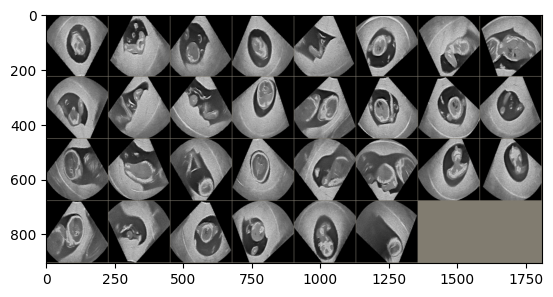

In [5]:
folderlocation = '/kaggle/working/'
image_datasets = {x: datasets.ImageFolder(os.path.join(folderlocation, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataloaders_test = {'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=24,
                                             shuffle=False, num_workers=0)}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = 'cuda'#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None): 
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.507, 0.487, 0.441])
    std = np.array([0.267, 0.256, 0.276])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#import matplotlib.pyplot as plt
#plt.rcParams["figure.dpi"] = 200

#plt.savefig('Transformed.pdf')  

imshow(out)#, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
          
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

In [8]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=3)

Epoch 0/2
----------
train Loss: 0.4925 Acc: 0.7964
val Loss: 0.3952 Acc: 0.8044

Epoch 1/2
----------
train Loss: 0.2618 Acc: 0.8795
val Loss: 0.2150 Acc: 0.8984

Epoch 2/2
----------
train Loss: 0.1914 Acc: 0.9187
val Loss: 0.1716 Acc: 0.9252

Training complete in 34m 36s
Best val Acc: 0.925215


## Testing by discarding the background class

In [9]:
y_pred = []
y_true = []
output_all =[]

# iterate over test data
for inputs, labels in dataloaders_test['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model_ft(inputs) # Feed Network
        output = output[:,0:2]

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

Test Accuracy: 0.9301555776233036


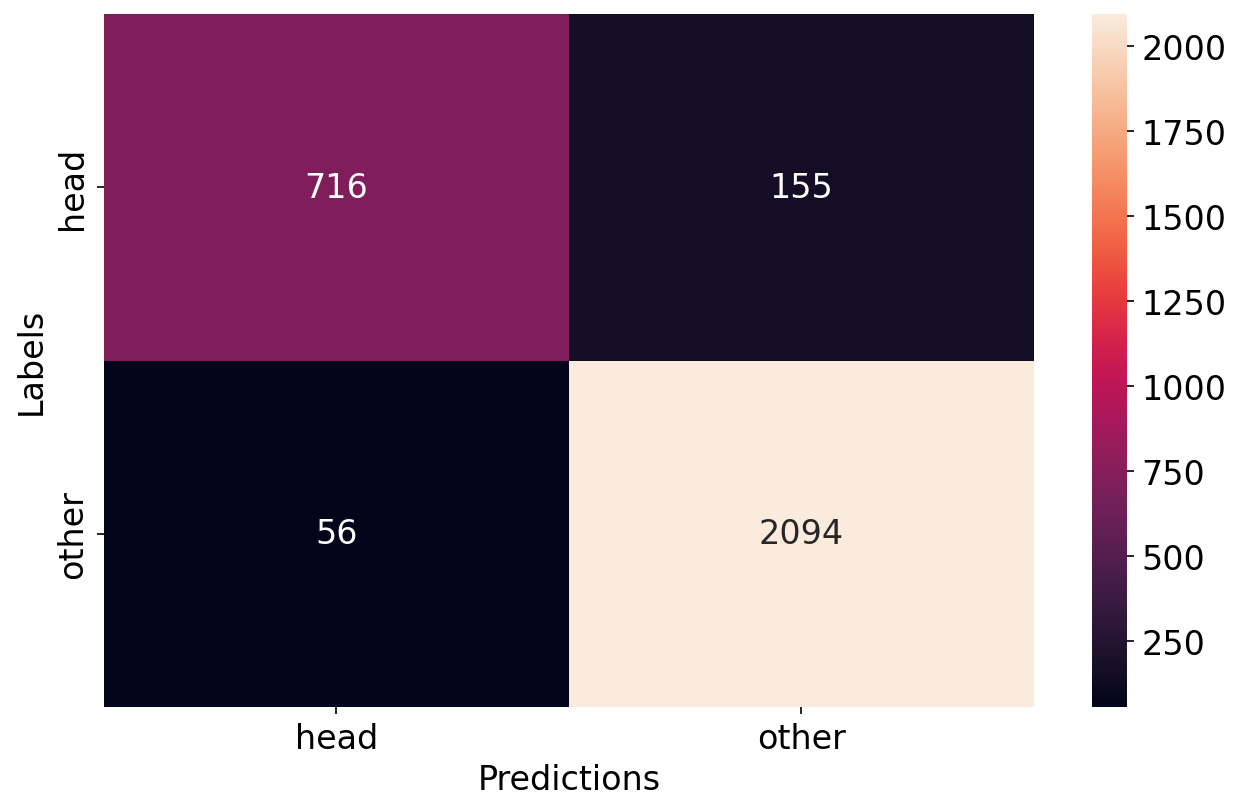

In [10]:
test_accuracy = 0
for iter1 in range(len(y_true)):
    if y_true[iter1] == y_pred[iter1]:
        test_accuracy = test_accuracy + 1

print('Test Accuracy:',test_accuracy/len(y_true))

# constant for classes
classes = ('head', 'other')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])



plt.figure(figsize = (10,6),dpi=150)
plt.rcParams['font.size'] = '16'
fig = sn.heatmap(df_cm, annot=True, fmt=".0f")
plt.ylabel("Labels")
plt.xlabel("Predictions")
plt.show(fig)

fig.figure.savefig('Confusion_test.pdf', bbox_inches = 'tight')

In [11]:
shutil.rmtree('/kaggle/working/test')
shutil.rmtree('/kaggle/working/train')
shutil.rmtree('/kaggle/working/val')